### BEAM PROFILE - TELESCOPING LENS SYSTEM (LB1471-C)

1st lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2

2nd lens (plano-convex): LA1461-C, F = 249.2mm, BFL = 247.4 

3rd lens (bi-convex): LB1471-C, F = 50.0mm, BFL = 48.2mm

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_FOS_collimating_sys.png


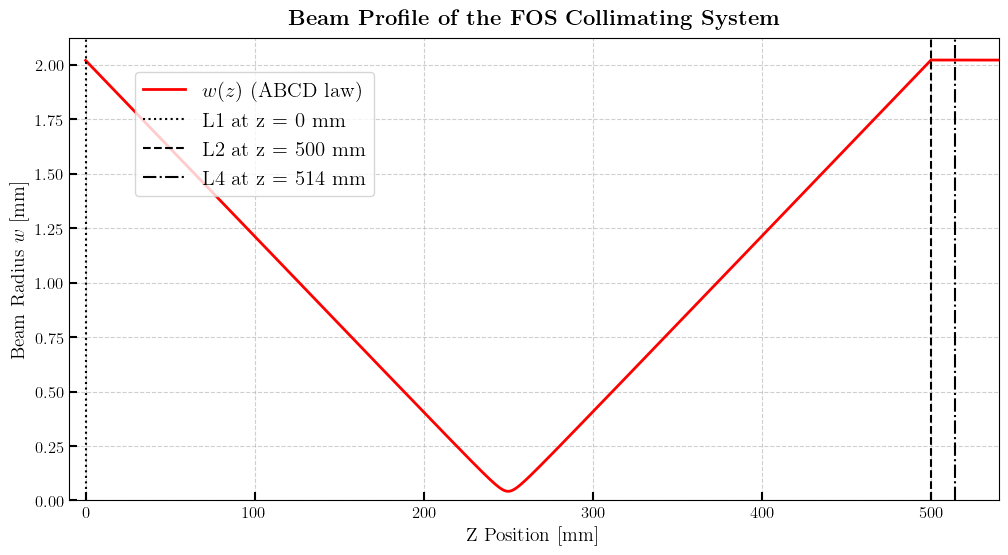


THEORETICAL WAIST SUMMARY
 Min Waist (ABCD law): 41.92 μm at z = 249.75 mm


In [8]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
# Check if the font path exists, otherwise fall back to default settings
if os.path.exists(font_path):
    cmu_serif = fm.FontProperties(fname=font_path)
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern']
else:
    print(f"Warning: CMU font not found at {font_path}. Using default Matplotlib settings.")
    plt.rcParams['text.usetex'] = False # Disable LaTeX if font is missing

# Data paths (kept for W0_initial extraction function, though experimental data is not plotted)
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

# --- Updated Constants and Lens Positions ---
focal_length1 = 250.0 # Focal length of L1
focal_length2 = 250.0 # Focal length of L2
z_lens1 = 0.0         # Position of L1
z_lens2 = 500.0       # Position of L2
z_L3_target = 514.0   # Target position for L3

wavelength = 1.064e-3 # wavelength in mm

# --- Function to get initial beam waist (kept to preserve starting W0 value logic) ---
def get_initial_beam_waist(file_path):
    """Reads the initial beam waist from the specified file."""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
                width_x_initial = float(line.split()[2])/2 
            if found_2nd_moments and "Width y" in line:
                # "
                width_y_initial = float(line.split()[2])/2 
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2 # Use average
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
    
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Rayleigh range of initial beam
z_R_initial = np.pi * W0_initial_guess**2 / wavelength 
# Beam parameter at z = 0 (L1 position)
q0 = 0 + 1j * z_R_initial 

# --- ABCD Law Calculation ---

# 1. Apply the first lens transformation at z = z_lens1 (0 mm)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after L1

# 2. Propagate to second lens position (z_lens2 = 500 mm)
z_to_lens2 = z_lens2 - z_lens1
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1) # Beam parameter just before L2

# 3. Second lens transformation at z = z_lens2 (500 mm)
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2) # Beam parameter just after L2

# --- Theoretical z-values for plotting ---
z_theoretical1 = np.linspace(z_lens1, z_lens2, 1000) # Between L1 and L2
# After L2 (propagate up to 2 * z_lens2 for visualization)
z_theoretical2 = np.linspace(z_lens2, z_lens2 * 2.5, 2000) 
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)

# --- Propagate the beam between L1 and L2 ---
for i, z in enumerate(z_theoretical1):
    B_free = z - z_lens1
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan

# --- Propagate the beam after L2 ---
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: 
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan

# Combine theoretical data for plotting
z_theoretical = np.concatenate([z_theoretical1, z_theoretical2])
W_theoretical = np.concatenate([W_theoretical1, W_theoretical2])

# Find theoretical minimum waist and its position
finite_W = W_theoretical[~np.isnan(W_theoretical)]
finite_Z = z_theoretical[~np.isnan(W_theoretical)]
if np.any(np.isfinite(finite_W)):
    min_waist_theo = np.min(finite_W) * 1000
    min_waist_theo_idx = np.argmin(finite_W)
    z_focal_theo = finite_Z[min_waist_theo_idx]
else:
    min_waist_theo = np.nan
    z_focal_theo = np.nan

# --- Plotting ---

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Theoretical curve
plt.plot(z_theoretical, W_theoretical, color='red', linestyle='-', linewidth=2, label=r'$w (z)$ (ABCD law)')

# Vertical lines for lenses
plt.axvline(x=z_lens1, color='k', linestyle=':', label=f'L1 at z = {z_lens1:.0f} mm')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'L2 at z = {z_lens2:.0f} mm')
plt.axvline(x=z_L3_target, color='k', linestyle='-.', label=f'L4 at z = {z_L3_target:.0f} mm')

# Theoretical minimum
'''if np.isfinite(min_waist_theo):
    plt.plot(z_focal_theo, min_waist_theo/1000.0,
             'o', mec='red', mfc='none', mew=2, ms=10, label=r'$w_{0,\rm{theo}}$')'''

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the FOS Collimating System}',
          fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.06, 0.95), loc='upper left', fontsize=15, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Origin at bottom-left
plt.xlim(left=z_lens1 - 10, right=z_lens2 +40)
plt.ylim(bottom=0)

save_beam_ABCD = os.path.join(fig_dir, "beam_profile_ABCD_FOS_collimating_sys.png")
plt.savefig(save_beam_ABCD, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSaved: {save_beam_ABCD}")
plt.show()
plt.close('all')

# Print Theoretical Waist Summary
print("\nTHEORETICAL WAIST SUMMARY")
if np.isfinite(min_waist_theo):
    print(f" Min Waist (ABCD law): {min_waist_theo:.2f} μm at z = {z_focal_theo:.2f} mm")
else:
    print(" No finite theoretical waist found.")

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_FOS_collimating_sys.png


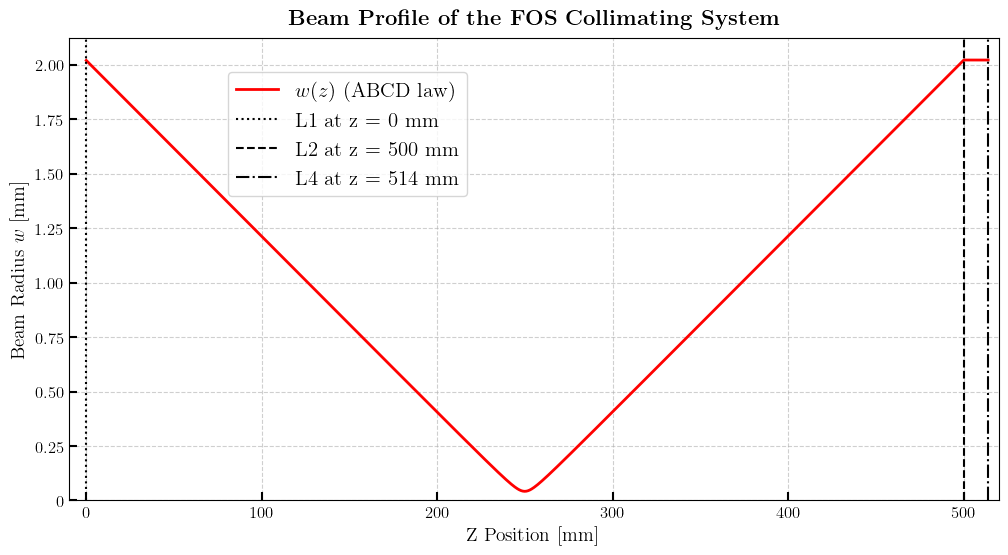


THEORETICAL WAIST SUMMARY
 Min Waist (ABCD law): 41.92 μm at z = 249.75 mm


In [11]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit
from matplotlib.ticker import FuncFormatter

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
# Check if the font path exists, otherwise fall back to default settings
if os.path.exists(font_path):
    cmu_serif = fm.FontProperties(fname=font_path)
    plt.rcParams['text.usetex'] = True
    plt.rcParams['font.family'] = 'serif'
    plt.rcParams['font.serif'] = ['Computer Modern']
else:
    print(f"Warning: CMU font not found at {font_path}. Using default Matplotlib settings.")
    plt.rcParams['text.usetex'] = False # Disable LaTeX if font is missing

# Data paths (kept for W0_initial extraction function, though experimental data is not plotted)
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

# --- Updated Constants and Lens Positions ---
focal_length1 = 250.0 # Focal length of L1
focal_length2 = 250.0 # Focal length of L2
z_lens1 = 0.0         # Position of L1
z_lens2 = 500.0       # Position of L2
z_L3_target = 514.0   # Target position for L3 (L4 in the text)

wavelength = 1.064e-3 # wavelength in mm

# --- Custom Y-axis Formatter (NEW) ---
def custom_y_formatter(y, pos):
    """Formats 0 as '0' and all other values as '.2f'."""
    if y == 0:
        return '0'
    return f'{y:.2f}'

# --- Function to get initial beam waist (kept to preserve starting W0 value logic) ---
def get_initial_beam_waist(file_path):
    """Reads the initial beam waist from the specified file."""
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
        
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
                width_x_initial = float(line.split()[2])/2 
            if found_2nd_moments and "Width y" in line:
                # "
                width_y_initial = float(line.split()[2])/2 
        
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Width x' or 'Width y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2 # Use average
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
    
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Rayleigh range of initial beam
z_R_initial = np.pi * W0_initial_guess**2 / wavelength 
# Beam parameter at z = 0 (L1 position)
q0 = 0 + 1j * z_R_initial 

# --- ABCD Law Calculation ---

# 1. Apply the first lens transformation at z = z_lens1 (0 mm)
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after L1

# 2. Propagate to second lens position (z_lens2 = 500 mm)
z_to_lens2 = z_lens2 - z_lens1
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1) # Beam parameter just before L2

# 3. Second lens transformation at z = z_lens2 (500 mm)
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2) # Beam parameter just after L2

# --- Theoretical z-values for plotting ---
z_theoretical1 = np.linspace(z_lens1, z_lens2, 1000) # Between L1 and L2
# After L2 (propagate UP TO z_L3_target for visualization) (MODIFIED)
z_theoretical2 = np.linspace(z_lens2, z_L3_target, 2000) 
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)

# --- Propagate the beam between L1 and L2 ---
for i, z in enumerate(z_theoretical1):
    B_free = z - z_lens1
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan

# --- Propagate the beam after L2 (stopping at L3/L4 position) ---
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: 
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan

# Combine theoretical data for plotting
z_theoretical = np.concatenate([z_theoretical1, z_theoretical2])
W_theoretical = np.concatenate([W_theoretical1, W_theoretical2])

# Find theoretical minimum waist and its position
finite_W = W_theoretical[~np.isnan(W_theoretical)]
finite_Z = z_theoretical[~np.isnan(W_theoretical)]
if np.any(np.isfinite(finite_W)):
    min_waist_theo = np.min(finite_W) * 1000
    min_waist_theo_idx = np.argmin(finite_W)
    z_focal_theo = finite_Z[min_waist_theo_idx]
else:
    min_waist_theo = np.nan
    z_focal_theo = np.nan

# --- Plotting ---

plt.figure(figsize=(12, 6))
ax = plt.gca()

# Theoretical curve
plt.plot(z_theoretical, W_theoretical, color='red', linestyle='-', linewidth=2, label=r'$w (z)$ (ABCD law)')

# Vertical lines for lenses
plt.axvline(x=z_lens1, color='k', linestyle=':', label=f'L1 at z = {z_lens1:.0f} mm')
plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'L2 at z = {z_lens2:.0f} mm')
plt.axvline(x=z_L3_target, color='k', linestyle='-.', label=f'L4 at z = {z_L3_target:.0f} mm')

# Theoretical minimum
'''if np.isfinite(min_waist_theo):
    plt.plot(z_focal_theo, min_waist_theo/1000.0,
             'o', mec='red', mfc='none', mew=2, ms=10, label=r'$w_{0,\rm{theo}}$')'''

plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the FOS Collimating System}',
          fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.16, 0.95), loc='upper left', fontsize=15, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Apply custom Y-axis formatter (NEW)
ax.yaxis.set_major_formatter(FuncFormatter(custom_y_formatter))

# Origin at bottom-left
plt.xlim(left=z_lens1 - 10, right=z_lens2 + 20)
plt.ylim(bottom=0)

save_beam_ABCD = os.path.join(fig_dir, "beam_profile_ABCD_FOS_collimating_sys.png")
plt.savefig(save_beam_ABCD, dpi=300, bbox_inches='tight', facecolor='white')
print(f"\nSaved: {save_beam_ABCD}")
plt.show()
plt.close('all')

# Print Theoretical Waist Summary
print("\nTHEORETICAL WAIST SUMMARY")
if np.isfinite(min_waist_theo):
    print(f" Min Waist (ABCD law): {min_waist_theo:.2f} μm at z = {z_focal_theo:.2f} mm")
else:
    print(" No finite theoretical waist found.")

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm
z = 20 mm, Waist_x = 1.300 mm, Waist_y = 1.202 mm
z = 30 mm, Waist_x = 0.886 mm, Waist_y = 0.779 mm
z = 40 mm, Waist_x = 0.467 mm, Waist_y = 0.400 mm
z = 50 mm, Waist_x = 0.053 mm, Waist_y = 0.048 mm
z = 60 mm, Waist_x = 0.415 mm, Waist_y = 0.389 mm
z = 70 mm, Waist_x = 0.742 mm, Waist_y = 0.692 mm
z = 80 mm, Waist_x = 1.053 mm, Waist_y = 0.991 mm
z = 90 mm, Waist_x = 1.472 mm, Waist_y = 1.409 mm
z = 100 mm, Waist_x = 1.954 mm, Waist_y = 1.852 mm
z = 110 mm, Waist_x = 2.228 mm, Waist_y = 2.123 mm
z = 120 mm, Waist_x = 2.618 mm, Waist_y = 2.442 mm
z = 130 mm, Waist_x = 3.058 mm, Waist_y = 2.881 mm
z = 140 mm, Waist_x = 3.407 mm, Waist_y = 3.193 mm

BEAM WAIST SUMMARY
Experimental (Lens 1):
 Min Waist X: 53.10 μm
 Min Waist Y: 47.78 μm
Theoretical (After Lens 1):
 Min Waist: 8.39 μm
 Max Waist: 10.10 mm
Theoretical (After Lens 2):
 Min Waist: 10.10 mm
 Max Waist: 10.10 mm
Theoretical (After Lens 3):
 Min Waist: 1.68

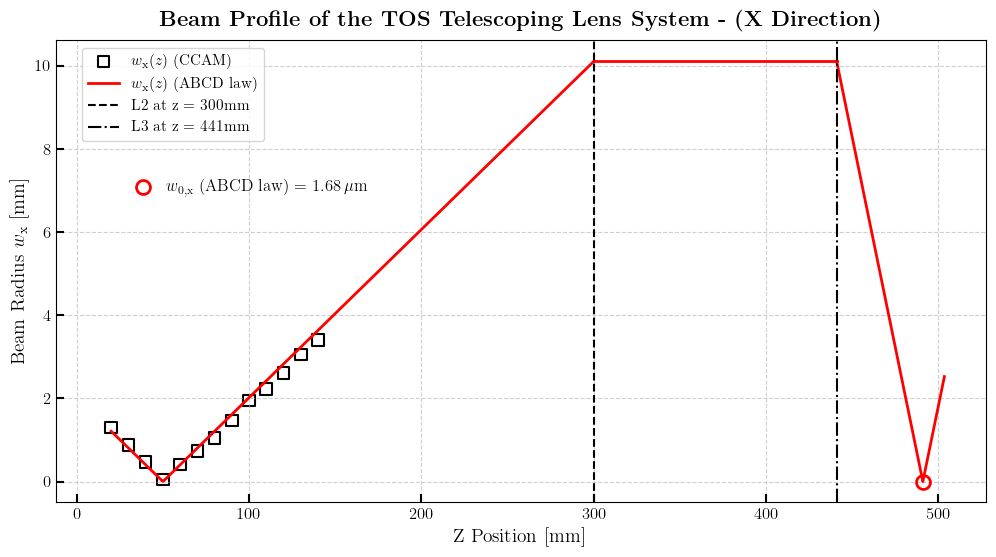

Saved: /Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C/fig/beam_profile_ABCD_y_TOS_telescoping_sys.png


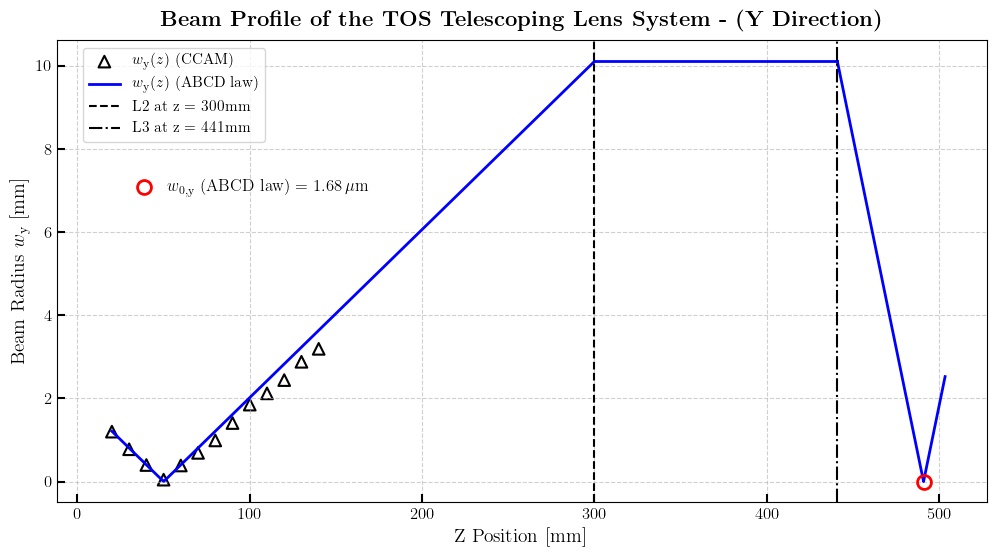

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from scipy.optimize import curve_fit

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)

z_values = []
width_x = []
width_y = []

# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])
    if z <= 149:
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2])/2)
            if "Width y" in line:
                width_y.append(float(line.split()[2])/2)

z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)

sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]

# Constants
focal_length1 = 50.0
focal_length2 = 250.0
focal_length3 = 50.0
wavelength = 1.064e-3
z_lens2 = 300
z_lens3 = 441

# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
       
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])/2 # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])/2 # "
       
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
    
# Beam waist after the lens (at focal length)
W0 = width_x.min() # Minimum width from data
z_waist = z_values[np.argmin(width_x)] # Position of the waist
z_R = np.pi * W0**2 / wavelength # Rayleigh range at the waist in mm

# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)

# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial # Beam parameter at z = 0 (before the first lens)

# Apply the first lens transformation at z = 0
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after the first lens

# Propagate to second lens position
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)

# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")

# Propagate to third lens position
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")

# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")

# Theoretical z-values
z_theoretical1 = np.linspace(min(z_values[z_values < z_lens2]), z_lens2, 1000)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 1000)
z_focal_expected = z_lens3 + focal_length3
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 5, 200),
    np.linspace(z_focal_expected - 5, z_focal_expected + 5, 10000),
    np.linspace(z_focal_expected + 5, z_lens3 + focal_length3 * 1.25, 200)
])
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)

# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan

# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan

# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")

# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")

# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1)
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2)

# Theoretical focal position after the third lens
min_waist_theo3_idx = np.argmin(W_theoretical3[~np.isnan(W_theoretical3)])
z_focal_theo3 = z_theoretical3[~np.isnan(W_theoretical3)][min_waist_theo3_idx]

# Ensure there are finite theoretical values after lens3
if np.any(np.isfinite(W_theoretical3)):
    finite_W3 = W_theoretical3[~np.isnan(W_theoretical3)]
    min_waist_theo3 = np.min(finite_W3) * 1000
    max_waist_theo3 = np.max(finite_W3)
    min_waist_theo3_idx = np.argmin(finite_W3)
    z_focal_theo3 = z_theoretical3[~np.isnan(W_theoretical3)][min_waist_theo3_idx]
else:
    min_waist_theo3 = np.nan
    max_waist_theo3 = np.nan
    z_focal_theo3 = np.nan

# Theoretical focal position after the third lens (already computed above)
print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1):")
print(f" Min Waist X: {min_waist_exp_x:.2f} μm")
print(f" Min Waist Y: {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After Lens 1):")
print(f" Min Waist: {min_waist_theo1:.2f} μm")
print(f" Max Waist: {max_waist_theo1:.2f} mm")
print(f"Theoretical (After Lens 2):")
print(f" Min Waist: {min_waist_theo2:.2f} mm")
print(f" Max Waist: {max_waist_theo2:.2f} mm")
print(f"Theoretical (After Lens 3):")
if np.isfinite(min_waist_theo3):
    print(f" Min Waist: {min_waist_theo3:.2f} μm at z = {z_focal_theo3:.2f} mm")
    print(f" Max Waist: {max_waist_theo3:.2f} mm")
else:
    print(" No finite theoretical waist found after L3.")

# Plot Width x
plt.figure(figsize=(12, 6))
ax = plt.gca()
mask1 = z_values < 300

# Experimental data: excluding the minimum point (drawn in red)
idx_min_x = np.argmin(width_x)
mask_plot_x = mask1 & (np.arange(len(z_values)) != idx_min_x)
plt.scatter(z_values, width_x, facecolors='none', edgecolors='black', 
            label=r'$w_{\rm{x}} (z)$ (CCAM)', marker='s', s=70, linewidths=1.5) # z_values[mask_plot_x], width_x[mask_plot_x]

#  Red square replaces black at experimental minimum 
#plt.plot(z_values[idx_min_x], width_x[idx_min_x],'s', mec='red', mfc='none', mew=2, ms=10)

# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='red', linestyle='-', linewidth=2, label=r'$w_{\rm{x}} (z)$ (ABCD law)')
plt.plot(z_theoretical2, W_theoretical2, color='red', linestyle='-', linewidth=2)
plt.plot(z_theoretical3, W_theoretical3, color='red', linestyle='-', linewidth=2)

# Red circle for theoretical min after L3
if np.isfinite(min_waist_theo3):
    plt.plot(z_focal_theo3, min_waist_theo3/1000.0,
             'o', mec='red', mfc='none', mew=2, ms=10)

plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'L2 at z = {z_lens2}mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'L3 at z = {z_lens3}mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w_{\rm{x}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the TOS Telescoping Lens System - (X Direction)}',
          fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.02, 1.0), loc='upper left', fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Origin at bottom-left
plt.xlim(left=-12)
plt.ylim(bottom=-0.5)

# LaTeX result box (no dummy points on main plot) ---
inset = ax.inset_axes([0.06, 0.40, 0.33, 0.33])
inset.axis('off')
# Use handle-only legend entries
'''from matplotlib.lines import Line2D
handles = [
    Line2D([0], [0], marker='s', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
           label=rf'$w_{{0,\rm{{x}}}}$ (CCAM) = ${min_waist_exp_y:.1f}\,\mu\mathrm{{m}}$'),
]
if np.isfinite(min_waist_theo3):
    handles.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
               label=rf'$w_{{0,\rm{{x}}}}$ (ABCD law) = ${min_waist_theo3:.1f}\,\mu\mathrm{{m}}$')
    )'''
from matplotlib.lines import Line2D
if np.isfinite(min_waist_theo3):
    handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
               label=rf'$w_{{0,\rm{{x}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$')
    ]
inset.legend(handles=handles, bbox_to_anchor=(0.02, 1.0), loc='upper left', fontsize=12, frameon=False, handlelength=1.2)

save_beam_ABCD_x = os.path.join(fig_dir, "beam_profile_ABCD_x_TOS_telescoping_sys.png")
plt.savefig(save_beam_ABCD_x, dpi=300, bbox_inches='tight', facecolor='white',
            bbox_extra_artists=[ax.get_legend(), inset])
print(f"Saved: {save_beam_ABCD_x}")
plt.show()
plt.close('all')

# Plot Width y
plt.figure(figsize=(12, 6))
ax = plt.gca()

# Experimental data: exclude the minimum point 
idx_min_y = np.argmin(width_y)
mask_plot_y = mask1 & (np.arange(len(z_values)) != idx_min_y)
plt.scatter(z_values, width_y, facecolors='none', edgecolors='black', label=r'$w_{\rm{y}} (z)$ (CCAM)', 
            marker='^', s=70, linewidths=1.5)# MASK TO SHOW EXP MIN IN RED: z_values[mask_plot_y], width_y[mask_plot_y]
# Red triangle replaces black at experimental minimum
#plt.plot(z_values[idx_min_y], width_y[idx_min_y],'^', mec='red', mfc='none', mew=2, ms=10)

# Theoretical curves
plt.plot(z_theoretical1, W_theoretical1, color='blue', linestyle='-', linewidth=2,
         label=r'$w_{\rm{y}} (z)$ (ABCD law)')
plt.plot(z_theoretical2, W_theoretical2, color='blue', linestyle='-', linewidth=2)
plt.plot(z_theoretical3, W_theoretical3, color='blue', linestyle='-', linewidth=2)

# Red circle for theoretical min after L3 
if np.isfinite(min_waist_theo3):
    plt.plot(z_focal_theo3, min_waist_theo3/1000.0, 'o', mec='red', mfc='none', mew=2, ms=10)

plt.axvline(x=z_lens2, color='k', linestyle='--', label=f'L2 at z = {z_lens2}mm')
plt.axvline(x=z_lens3, color='k', linestyle='-.', label=f'L3 at z = {z_lens3}mm')
plt.xlabel(r'Z Position [mm]', fontsize=14)
plt.ylabel(r'Beam Radius $w_{\rm{y}}$ [mm]', fontsize=14)
plt.title(r'\textbf{Beam Profile of the TOS Telescoping Lens System - (Y Direction)}',
          fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.02, 1.0), loc='upper left', fontsize=11, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.grid(True, linestyle='--', alpha=0.6)

# Origin at bottom-left 
plt.xlim(left=-12)
plt.ylim(bottom=-0.5)

# LaTeX result box 
inset = ax.inset_axes([0.06, 0.4, 0.33, 0.33])
inset.axis('off')
'''handles = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
           label=rf'$w_{{0,\rm{{y}}}}$ (CCAM) = ${min_waist_exp_y:.1f}\,\mu\mathrm{{m}}$'),
]
if np.isfinite(min_waist_theo3):
    handles.append(
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
               label=rf'$w_{{0,\rm{{y}}}}$ (ABCD law) = ${min_waist_theo3:.1f}\,\mu\mathrm{{m}}$') # + rf'$\mathbf{{@ z}} = {z_focal_theo3:.1f}\,\mathrm{{mm}}$' FOR Z POSITION
    )
handles = [
    Line2D([0], [0], marker='^', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
           label=rf'$w_{{0,\rm{{y}}}}$ (CCAM) = ${min_waist_exp_y:.1f}\,\mu\mathrm{{m}}$'),
]'''
if np.isfinite(min_waist_theo3):
    handles = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='none', markeredgecolor='red', markersize=10, markeredgewidth=2.0,
               label=rf'$w_{{0,\rm{{y}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$') # + rf'$\mathbf{{@ z}} = {z_focal_theo3:.1f}\,\mathrm{{mm}}$' FOR Z POSITION
    ]
inset.legend(handles=handles, bbox_to_anchor=(0.02, 1.0), loc='upper left', fontsize=12, frameon=False, handlelength=1.2)

save_beam_ABCD_y = os.path.join(fig_dir, "beam_profile_ABCD_y_TOS_telescoping_sys.png")
plt.savefig(save_beam_ABCD_y, dpi=300, bbox_inches='tight', facecolor='white',
            bbox_extra_artists=[ax.get_legend(), inset])
print(f"Saved: {save_beam_ABCD_y}")
plt.show()
plt.close('all')

### CONVERGENCE TEST (LB1471-C)

q1 = -5.00e+01+8.30e-03j
Saved: /Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/fig/beam_waist_convergence.png


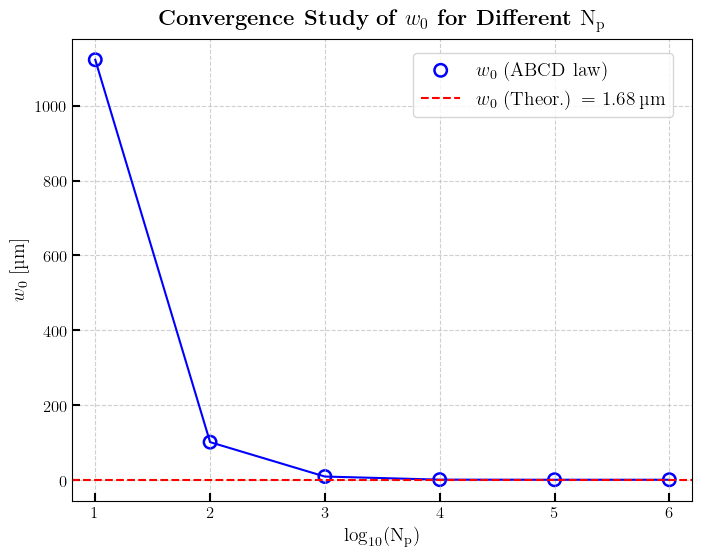


CONVERGENCE TEST SUMMARY
Theoretical Min Waist: 1.6766 μm
Points: 10, Min Waist: 1122.2232 μm, Difference from Theoretical: 1120.5466 μm
Points: 100, Min Waist: 102.0337 μm, Difference from Theoretical: 100.3571 μm
Points: 1000, Min Waist: 10.2479 μm, Difference from Theoretical: 8.5713 μm
Points: 10000, Min Waist: 1.9573 μm, Difference from Theoretical: 0.2806 μm
Points: 100000, Min Waist: 1.6797 μm, Difference from Theoretical: 0.0030 μm
Points: 1000000, Min Waist: 1.6767 μm, Difference from Theoretical: 0.0000 μm


In [150]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import os

# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']

# Ensure siunitx is available 
plt.rcParams['text.latex.preamble'] = r'\usepackage{siunitx}'

# Constants
focal_length = 50.0  # in mm
wavelength = 1.064e-3  # in mm
W0_initial =  20.20 / 2 # Average of Waist x and Waist y in mm -> /2 TO CONVERT TO RADIUS
z_R_initial = np.pi * W0_initial**2 / wavelength  # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial  # Beam parameter at z = 0

# Theoretical beam waist using equation from Seigmann
W0_theoretical = (wavelength * focal_length) / (np.pi * W0_initial)

# Apply the lens transformation at z = 0
A_lens = 1
B_lens = 0
C_lens = -1 / focal_length
D_lens = 1
q1 = (A_lens * q0 + B_lens) / (C_lens * q0 + D_lens)  # Beam parameter just after the lens
print(f"q1 = {q1:.2e}")

# Number of points to test 
n_points_list = [10, 100, 1000, 10000, 100000, 1000000]
min_waists = []

# Propagation range
z_min = 0
z_max = focal_length * 2

# Convergence test
for n_points in n_points_list:
    z_theoretical = np.linspace(z_min, z_max, n_points)
    W_theoretical = np.zeros_like(z_theoretical)
    
    for i, z in enumerate(z_theoretical):
        A_free = 1
        B_free = z
        C_free = 0
        D_free = 1
        q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
        inv_q_new = 1 / q_new
        if inv_q_new.imag < 0:  # tolerance
            W_theoretical[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
        else:
            W_theoretical[i] = np.nan
            print(f"n_points = {n_points}, z = {z:.2f}, q_new = {q_new:.2e}, inv_q_new.imag = {inv_q_new.imag:.2e}")
    
    if np.all(np.isnan(W_theoretical)):
        print(f"Error: All W_theoretical values are NaN for n_points = {n_points}")
        min_waists.append(np.nan)
    else:
        min_waist = np.min(W_theoretical[~np.isnan(W_theoretical)])
        min_waists.append(min_waist)

# Convert to μm for plotting
min_waists = np.array(min_waists) * 1000
W0_theoretical_um = W0_theoretical * 1000
log_n_points = np.log10(n_points_list)

# Plotting 
plt.figure(figsize=(8, 6))
#plt.plot(log_n_points, min_waists, edgecolors = 'red', marker='o', linestyle='-', label=r'$w_0$ (ABCD law)')
#plt.axhline(y=W0_theoretical_um, color='blue', linestyle='--', label=r'$w_{0}$ (Theor.) = \SI{' + f'{W0_theoretical_um:.2f}' + r'}{\micro\meter}')
# --- CHANGED: Use scatter with open red circles ---
plt.scatter(log_n_points, min_waists,
            facecolors='none', edgecolors='blue', marker='o',
            s=80, linewidths=1.8, label=r'$w_0$ (ABCD law)')

# Connect the points with a line (optional, keeps continuity)
plt.plot(log_n_points, min_waists, color='blue', linestyle='-', linewidth=1.5)
plt.axhline(y=W0_theoretical_um, color='red', linestyle='--',
            label=r'$w_{{0}}$ (Theor.) = \SI{' + f'{W0_theoretical_um:.2f}' + r'}{\micro\meter}')
plt.xlabel(r'$\log_{10}$($\rm{N}_{\rm{p}}$)', fontsize=14)
plt.ylabel(r'$w_0$ [\si{\micro\meter}]', fontsize=14)
plt.title(r'\textbf{Convergence Study of $w_0$ for Different $\rm{N}_{\rm{p}}$}', fontsize=16, fontweight='bold', pad=10)
plt.legend(bbox_to_anchor=(0.985, 0.99), loc='upper right', fontsize=14, frameon=True)
plt.tick_params(axis='both', which='major', labelsize=12, length=6, width=1.5, direction='in')
plt.xlim(0.8, 6.2) # 42 , 56
#plt.set_ylim(bottom=-0.05, top=1.3)
plt.grid(True, linestyle='--', alpha=0.6)

# Save the plot
fig_dir = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/fig"
os.makedirs(fig_dir, exist_ok=True)
save_path = os.path.join(fig_dir, "beam_waist_convergence.png")
plt.savefig(save_path, dpi=300, bbox_inches='tight', facecolor='white')
print(f"Saved: {save_path}")
plt.show()

# Print summary
print("\nCONVERGENCE TEST SUMMARY")
print(f"Theoretical Min Waist: {W0_theoretical_um:.4f} μm")
for n, w in zip(n_points_list, min_waists):
    print(f"Points: {n}, Min Waist: {w:.4f} μm, Difference from Theoretical: {(w - W0_theoretical_um):.4f} μm")

### BEAM PROFILE OF L3 (LB1471-C)

Isolated the beam profile after L3. Comparing experimental data obtained with CCAM and BP against the theoretical beam propagation based on the ABCD law.

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm
z = 20 mm, Waist_x = 1.300 mm, Waist_y = 1.202 mm
z = 30 mm, Waist_x = 0.886 mm, Waist_y = 0.779 mm
z = 40 mm, Waist_x = 0.467 mm, Waist_y = 0.400 mm
z = 50 mm, Waist_x = 0.053 mm, Waist_y = 0.048 mm
z = 60 mm, Waist_x = 0.415 mm, Waist_y = 0.389 mm
z = 70 mm, Waist_x = 0.742 mm, Waist_y = 0.692 mm
z = 80 mm, Waist_x = 1.053 mm, Waist_y = 0.991 mm
z = 90 mm, Waist_x = 1.472 mm, Waist_y = 1.409 mm
z = 100 mm, Waist_x = 1.954 mm, Waist_y = 1.852 mm
z = 110 mm, Waist_x = 2.228 mm, Waist_y = 2.123 mm
z = 120 mm, Waist_x = 2.618 mm, Waist_y = 2.442 mm
z = 130 mm, Waist_x = 3.058 mm, Waist_y = 2.881 mm
z = 140 mm, Waist_x = 3.407 mm, Waist_y = 3.193 mm

=== LOADING CMOS & BP209 DATA (L3 @ z=0 in new frame) ===
Loaded 36 CMOS points (L3 @ z=0)
Loaded 72 BP209 points (L3 @ z=0)

BEAM WAIST SUMMARY
Experimental (Lens 1): Min Waist X = 53.10 μm, Y = 47.78 μm
Theoretical (After L3): Min Waist = 1.68 μm @ z = 50.00 mm (new fr

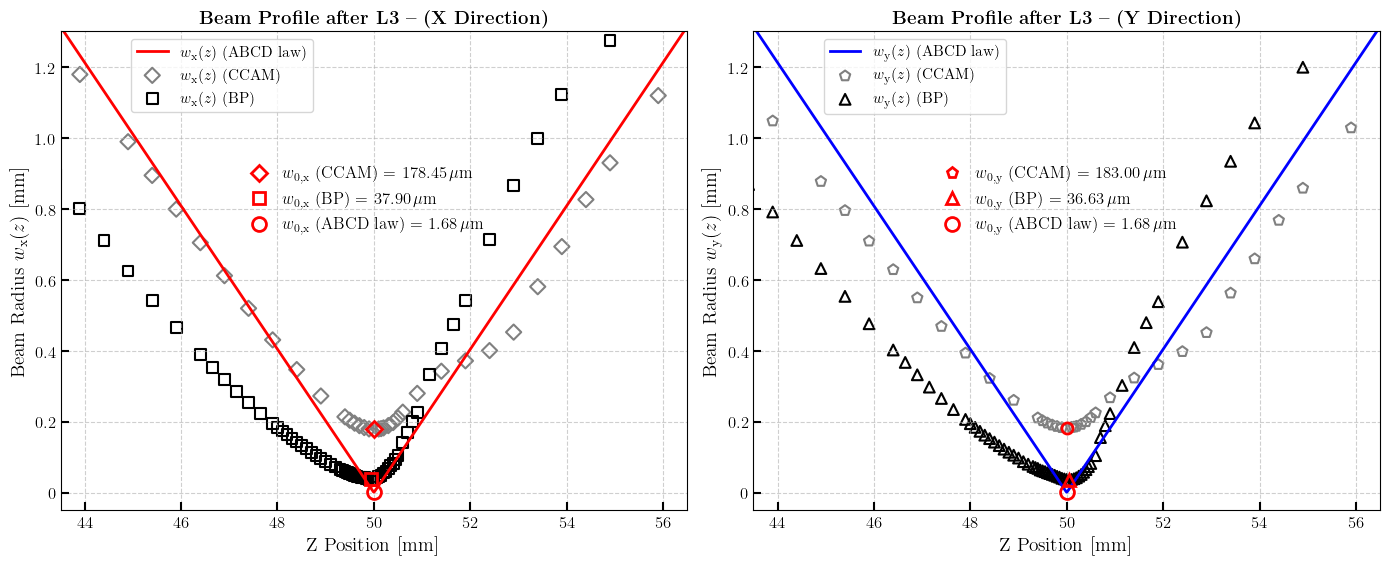

In [4]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
data_path_cmos = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/20251021_old_telescoping_LB1471-C_CMOS"
data_path_bp209 = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/251021_old_telescoping_LB1471-C"
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)
z_values = []
width_x = []
width_y = []
# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])
    if z <= 149:
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2])/2)
            if "Width y" in line:
                width_y.append(float(line.split()[2])/2)
z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)
sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]
# Constants
focal_length1 = 50.0
focal_length2 = 250.0
focal_length3 = 50.0
wavelength = 1.064e-3
z_lens2 = 300
z_lens3 = 441
# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
   
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])/2 # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])/2 # "
   
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
# Beam waist after the lens (at focal length)
W0 = width_x.min() # Minimum width from data
z_waist = z_values[np.argmin(width_x)] # Position of the waist
z_R = np.pi * W0**2 / wavelength # Rayleigh range at the waist in mm
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)
# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial # Beam parameter at z = 0 (before the first lens)
# Apply the first lens transformation at z = 0
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after the first lens
# Propagate to second lens position
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)
# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")
# Propagate to third lens position
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")
# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")
# Theoretical z-values
z_theoretical1 = np.linspace(0, z_lens2, 1000)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 1000)
z_focal_expected  = z_lens3 + focal_length3
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 5, 200),
    np.linspace(z_focal_expected - 5, z_focal_expected + 5, 10000),
    np.linspace(z_focal_expected + 5, z_lens3 + focal_length3 * 1.25, 200)
])
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)
# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan
# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan
# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")
# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")
# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1)
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2)
# Theoretical focal position after the third lens
valid_th3 = ~np.isnan(W_theoretical3)
if len(W_theoretical3[valid_th3]) > 0:
    min_waist_theo3_idx = np.argmin(W_theoretical3[valid_th3])
    z_focal_theo3 = z_theoretical3[valid_th3][min_waist_theo3_idx]
    min_waist_theo3 = W_theoretical3[valid_th3][min_waist_theo3_idx] * 1000
else:
    z_focal_theo3 = np.nan
    min_waist_theo3 = np.nan
# ----------------------------------------------------------------------
# LOAD CMOS & BP209 DATA — SHIFT L3 TO z=0 (new zero at L3 = 441 mm)
# ----------------------------------------------------------------------
print("\n=== LOADING CMOS & BP209 DATA (L3 @ z=0 in new frame) ===")
# CMOS
file_list_cmos = sorted([f for f in glob.glob(os.path.join(data_path_cmos, "*mm Beam Results.csv"))
                         if "before lens" not in os.path.basename(f).lower()])
z_cmos_raw, wx_cmos_raw, wy_cmos_raw = [], [], []
for file in file_list_cmos:
    z_str = os.path.basename(file).split('mm')[0].strip()
    try:
        z = float(z_str)
    except:
        continue
    with open(file, 'r') as f:
        lines = f.readlines()
    wx = wy = None
    for line in lines:
        if "Width x" in line:
            try:
                wx = float(line.split()[2])/2
            except:
                pass
        if "Width y" in line:
            try:
                wy = float(line.split()[2])/2
            except:
                pass
    if wx is not None and wy is not None:
        z_cmos_raw.append(z)
        wx_cmos_raw.append(wx)
        wy_cmos_raw.append(wy)
if len(z_cmos_raw) > 0:
    z_cmos = np.array(z_cmos_raw) + 15.40 #15.2 # 13.7 + 1.5 SHIFT FOR CCAM DATA
    wx_cmos = np.array(wx_cmos_raw)
    wy_cmos = np.array(wy_cmos_raw)
    min_wx_cmos = min(wx_cmos) * 1000
    min_wy_cmos = min(wy_cmos) * 1000
    print(f"Loaded {len(z_cmos)} CMOS points (L3 @ z=0)")
else:
    z_cmos = wx_cmos = wy_cmos = np.array([])
    min_wx_cmos = min_wy_cmos = np.nan
# BP209
file_list_bp209 = sorted([f for f in glob.glob(os.path.join(data_path_bp209, "*mm_#001.txt"))
                           if "before lens" not in os.path.basename(f).lower()],
                          key=lambda f: float(os.path.basename(f).split('mm')[0]))
z_bp_raw, wx_bp_raw, wy_bp_raw = [], [], []
for file in file_list_bp209:
    z_str = os.path.basename(file).split('mm')[0].strip()
    try:
        z = float(z_str)
    except:
        continue
    try:
        with open(file, 'r', encoding='latin1') as f:
            lines = f.readlines()
    except:
        continue
    wx = wy = None
    for line in lines:
        if line.strip() and len(line.split('\t')) > 16:
            parts = line.strip().split('\t')
            try:
                if parts[15] != '--' and parts[16] != '--':
                    wx = float(parts[15]) / 2 / 1000
                    wy = float(parts[16]) / 2 / 1000
                    break
            except:
                continue
    if wx is not None and wy is not None:
        z_bp_raw.append(z)
        wx_bp_raw.append(wx)
        wy_bp_raw.append(wy)
if len(z_bp_raw) > 0:
    z_bp = np.array(z_bp_raw) + 4.9 # +4.9 + 1.5 = 6.4# New z = (old_raw + 4.9) - 441 → L3 @ 0 SHIFT FOR BP209 DATA
    wx_bp = np.array(wx_bp_raw)
    wy_bp = np.array(wy_bp_raw)
    min_wx_bp = min(wx_bp) * 1000
    min_wy_bp = min(wy_bp) * 1000
    print(f"Loaded {len(z_bp)} BP209 points (L3 @ z=0)")
else:
    z_bp = wx_bp = wy_bp = np.array([])
    min_wx_bp = min_wy_bp = np.nan
print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1): Min Waist X = {min_waist_exp_x:.2f} μm, Y = {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After L3): Min Waist = {min_waist_theo3:.2f} μm @ z = {z_focal_theo3 - 441.0:.2f} mm (new frame)")
if len(wx_cmos) > 0:
    print(f"CMOS (after L3): Min X = {min_wx_cmos:.2f} μm, Min Y = {min_wy_cmos:.2f} μm")
if len(wx_bp) > 0:
    print(f"BP209 (after L3): Min X = {min_wx_bp:.2f} μm, Min Y = {min_wy_bp:.2f} μm")
# ----------------------------------------------------------------------
# PLOT ONLY AFTER L3: z_new = z_global - 441, from 0 to 60 mm
# ----------------------------------------------------------------------
# Shift theoretical curve
z_theoretical3_new = z_theoretical3 - 441.0
z_focal_theo3_new = z_focal_theo3 - 441.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# ------------------------------------------------------------------
#  Custom tick formatter: 0 → "0" , everything else → 1 decimal
# ------------------------------------------------------------------
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
def y_formatter(val, pos):
    return '0' if val == 0 else f'{val:.1f}'
y_fmt = FuncFormatter(y_formatter)

# -------------------------- X DIRECTION --------------------------
ax1.plot(z_theoretical3_new, W_theoretical3, color='red', lw=2,
         label=r'$w_{\rm x}(z)$ (ABCD law)')                     # <-- legend entry
if np.isfinite(min_waist_theo3):
    ax1.plot(z_focal_theo3_new, min_waist_theo3/1000,
             'o', mec='red', mfc='none', mew=2, ms=10)

# CMOS (CCAM)
if len(z_cmos) > 0:
    i_min_cx = np.argmin(wx_cmos)
    mask_cx = np.arange(len(wx_cmos)) != i_min_cx
    ax1.scatter(z_cmos[mask_cx], wx_cmos[mask_cx],
                facecolors='none', edgecolors='grey', marker='D',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{x}} (z)$ (CCAM)')                         # <-- legend entry
    ax1.plot(z_cmos[i_min_cx], wx_cmos[i_min_cx],
             'D', mec='red', mfc='none', mew=2, ms=8)

# BP209
if len(z_bp) > 0:
    i_min_bx = np.argmin(wx_bp)
    mask_bx = np.arange(len(wx_bp)) != i_min_bx
    ax1.scatter(z_bp[mask_bx], wx_bp[mask_bx],
                facecolors='none', edgecolors='black', marker='s',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{x}} (z)$ (BP)')                        # <-- legend entry
    ax1.plot(z_bp[i_min_bx], wx_bp[i_min_bx],
             's', mec='red', mfc='none', mew=2, ms=8)

ax1.axvline(x=0, color='k', linestyle='-.')
ax1.set_xlim(43.5, 56.5) 
ax1.set_ylim(bottom=-0.05, top=1.3)
ax1.set_xlabel(r'Z Position [mm]', fontsize=14)
ax1.set_ylabel(r'Beam Radius $w_{\rm x}(z)$ [mm]', fontsize=14)
ax1.set_title(r'\textbf{Beam Profile after L3 – (X Direction)}',
              fontsize=13.5, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=12,
                length=6, width=1.5, direction='in')
ax1.yaxis.set_major_formatter(y_fmt)
ax1.grid(True, linestyle='--', alpha=0.6)

# ---- main legend (inside the plot) ----
ax1.legend(bbox_to_anchor=(0.1, 1.0), loc='upper left', fontsize=11, frameon=True) # 0.02

# ---- inset result box (same style as reference) ----
inset_x = ax1.inset_axes([0.27, 0.42, 0.33, 0.33])
inset_x.axis('off')
handles_x = []
if len(wx_cmos) > 0:
    handles_x.append(Line2D([0], [0], marker='D', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (CCAM) = ${min_wx_cmos:.2f}\,\mu\mathrm{{m}}$'))
if len(wx_bp) > 0:
    handles_x.append(Line2D([0], [0], marker='s', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (BP) = ${min_wx_bp:.2f}\,\mu\mathrm{{m}}$'))
if np.isfinite(min_waist_theo3):
    handles_x.append(Line2D([0], [0], marker='o', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=10, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$'))
inset_x.legend(handles=handles_x, bbox_to_anchor=(0.02, 1.0),
               loc='upper left', fontsize=12, frameon=False,
               handlelength=1.2)

# -------------------------- Y DIRECTION --------------------------
ax2.plot(z_theoretical3_new, W_theoretical3, color='blue', lw=2,
         label=r'$w_{\rm y}(z)$ (ABCD law)')                     # <-- legend entry
if np.isfinite(min_waist_theo3):
    ax2.plot(z_focal_theo3_new, min_waist_theo3/1000,
             'o', mec='red', mfc='none', mew=2, ms=10)

# CMOS (CCAM)
if len(z_cmos) > 0:
    i_min_cy = np.argmin(wy_cmos)
    mask_cy = np.arange(len(wy_cmos)) != i_min_cy
    ax2.scatter(z_cmos[mask_cy], wy_cmos[mask_cy],
                facecolors='none', edgecolors='grey', marker='p',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{y}} (z)$ (CCAM)')                         # <-- legend entry
    ax2.plot(z_cmos[i_min_cy], wy_cmos[i_min_cy],
             'o', mec='red', mfc='none', mew=2, ms=8)

# BP209
if len(z_bp) > 0:
    i_min_by = np.argmin(wy_bp)
    mask_by = np.arange(len(wy_bp)) != i_min_by
    ax2.scatter(z_bp[mask_by], wy_bp[mask_by],
                facecolors='none', edgecolors='black', marker='^',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{y}} (z)$ (BP)')                        # <-- legend entry
    ax2.plot(z_bp[i_min_by], wy_bp[i_min_by],
             '^', mec='red', mfc='none', mew=2, ms=8)

ax2.axvline(x=0, color='k', linestyle='-.')
ax2.set_xlim(43.5, 56.5) # 42 , 56
ax2.set_ylim(bottom=-0.05, top=1.3)
ax2.set_xlabel(r'Z Position [mm]', fontsize=14)
ax2.set_ylabel(r'Beam Radius $w_{\rm y}(z)$ [mm]', fontsize=14)
ax2.set_title(r'\textbf{Beam Profile after L3 – (Y Direction)}',
              fontsize=13.5, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=12,
                length=6, width=1.5, direction='in')
ax2.yaxis.set_major_formatter(y_fmt)
ax2.grid(True, linestyle='--', alpha=0.6)

# ---- main legend (inside the plot) ----
ax2.legend(bbox_to_anchor=(0.1, 1.0), loc='upper left',
           fontsize=11, frameon=True)

# ---- inset result box (same style as reference) ----
inset_y = ax2.inset_axes([0.27, 0.42, 0.33, 0.33])
inset_y.axis('off')
handles_y = []
if len(wy_cmos) > 0:
    handles_y.append(Line2D([0], [0], marker='p', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (CCAM) = ${min_wy_cmos:.2f}\,\mu\mathrm{{m}}$'))
if len(wy_bp) > 0:
    handles_y.append(Line2D([0], [0], marker='^', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (BP) = ${min_wy_bp:.2f}\,\mu\mathrm{{m}}$'))
if np.isfinite(min_waist_theo3):
    handles_y.append(Line2D([0], [0], marker='o', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=10, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$'))
inset_y.legend(handles=handles_y, bbox_to_anchor=(0.02, 1.0),
               loc='upper left', fontsize=12, frameon=False,
               handlelength=1.2)

# -----------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_full = os.path.join(fig_dir, "beam_waist_L3.png")
plt.savefig(save_full, dpi=300, bbox_inches='tight', facecolor='white',
            bbox_extra_artists=[ax1.get_legend(), inset_x,
                                ax2.get_legend(), inset_y])
print(f"Saved post-L3 profile: {save_full}")
plt.show()

Comparison against data from a previous date:

Found beam waist before the lens: Waist x = 2.1205 mm, Waist y = 1.92 mm
z = 20 mm, Waist_x = 1.300 mm, Waist_y = 1.202 mm
z = 30 mm, Waist_x = 0.886 mm, Waist_y = 0.779 mm
z = 40 mm, Waist_x = 0.467 mm, Waist_y = 0.400 mm
z = 50 mm, Waist_x = 0.053 mm, Waist_y = 0.048 mm
z = 60 mm, Waist_x = 0.415 mm, Waist_y = 0.389 mm
z = 70 mm, Waist_x = 0.742 mm, Waist_y = 0.692 mm
z = 80 mm, Waist_x = 1.053 mm, Waist_y = 0.991 mm
z = 90 mm, Waist_x = 1.472 mm, Waist_y = 1.409 mm
z = 100 mm, Waist_x = 1.954 mm, Waist_y = 1.852 mm
z = 110 mm, Waist_x = 2.228 mm, Waist_y = 2.123 mm
z = 120 mm, Waist_x = 2.618 mm, Waist_y = 2.442 mm
z = 130 mm, Waist_x = 3.058 mm, Waist_y = 2.881 mm
z = 140 mm, Waist_x = 3.407 mm, Waist_y = 3.193 mm

=== LOADING CMOS & BP209 DATA (L3 @ z=0 in new frame) ===
Loaded 36 CMOS points (L3 @ z=0)
Loaded 45 BP209 points (L3 @ z=0)

BEAM WAIST SUMMARY
Experimental (Lens 1): Min Waist X = 53.10 μm, Y = 47.78 μm
Theoretical (After L3): Min Waist = 1.68 μm @ z = 50.00 mm (new fr

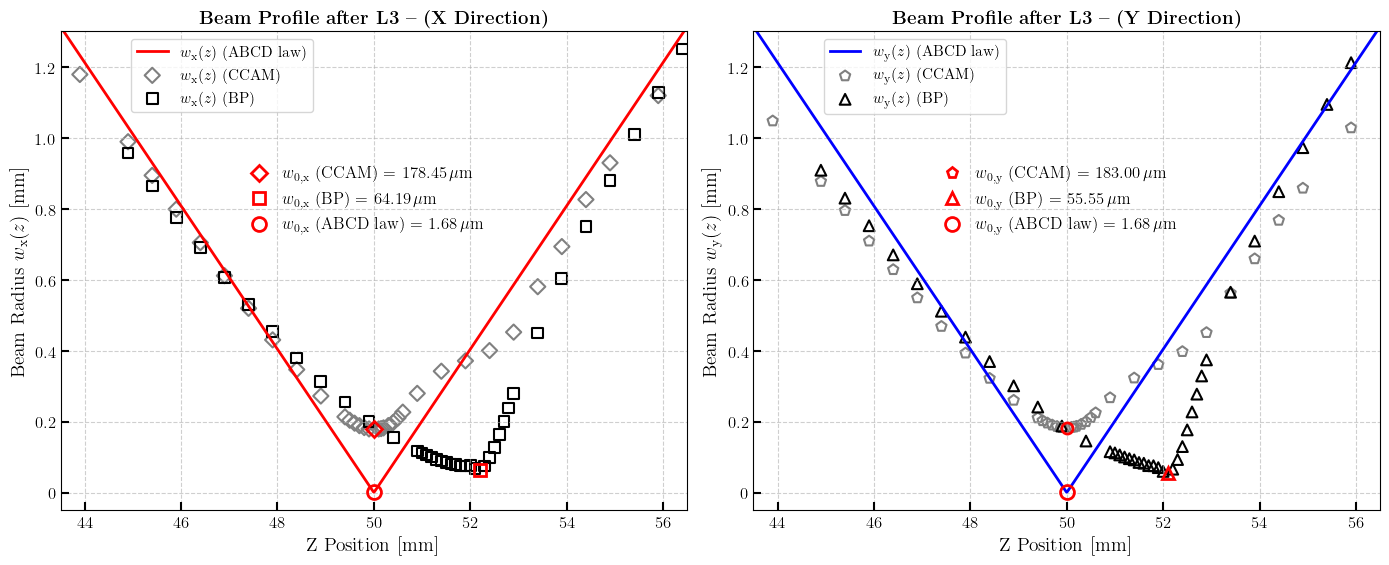

In [3]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.lines import Line2D
# Set up font properties for CMU Serif
font_path = "/Users/asca/Library/Fonts/cmunrm.ttf"
cmu_serif = fm.FontProperties(fname=font_path)
plt.rcParams['text.usetex'] = True
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Computer Modern']
# Data paths
data_path1 = "/Users/asca/Documents/University/Master Thesis/code/Data/Focus Laser/20250324/"
data_path_2 = "/Users/asca/Documents/University/Master Thesis/code/Data/BeamProfile/LB1471-C" # fig_dir
data_path_cmos = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/20251021_old_telescoping_LB1471-C_CMOS"
#data_path_bp209 = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/251021_old_telescoping_LB1471-C"
data_path_bp209 = "/Users/asca/Documents/University/Master Thesis/code/Data/slit scanning beam profiler/251015_old_telescoping_LB1471-C"
file_list1 = sorted([f for f in glob.glob(os.path.join(data_path1, "*mm Beam Results.csv"))
                     if "before lens" not in os.path.basename(f).lower()])
fig_dir = os.path.join(data_path_2, "fig")
os.makedirs(fig_dir, exist_ok=True)
z_values = []
width_x = []
width_y = []
# Extract first lens data:
for file in file_list1:
    filename = os.path.basename(file)
    z = int(filename.split('mm')[0])
    if z <= 149:
        z_values.append(z)
        with open(file, 'r') as f:
            lines = f.readlines()
        for i, line in enumerate(lines):
            if "Width x" in line:
                width_x.append(float(line.split()[2])/2)
            if "Width y" in line:
                width_y.append(float(line.split()[2])/2)
z_values = np.array(z_values)
width_x = np.array(width_x)
width_y = np.array(width_y)
sorted_indices = np.argsort(z_values)
z_values = z_values[sorted_indices]
width_x = width_x[sorted_indices]
width_y = width_y[sorted_indices]
# Constants
focal_length1 = 50.0
focal_length2 = 250.0
focal_length3 = 50.0
wavelength = 1.064e-3
z_lens2 = 300
z_lens3 = 441
# Function to get initial beam waist
def get_initial_beam_waist(file_path):
    try:
        with open(file_path, 'r') as f:
            lines = f.readlines()
        width_x_initial = None
        width_y_initial = None
        found_2nd_moments = False
   
        for i, line in enumerate(lines):
            if "2nd Moments" in line:
                found_2nd_moments = True
            if found_2nd_moments and "Width x" in line:
                width_x_initial = float(line.split()[2])/2 # /2 TO CONVERT TO RADIUS AND PLOT THE RADIUS IN THEORETICAL CURVE
            if found_2nd_moments and "Width y" in line:
                width_y_initial = float(line.split()[2])/2 # "
   
        if width_x_initial is None or width_y_initial is None:
            print(f"Error: Could not find 'Waist x' or 'Waist y' in {file_path}. Using default W0_initial = 4 mm.")
            return 4.0
        else:
            print(f"Found beam waist before the lens: Waist x = {width_x_initial} mm, Waist y = {width_y_initial} mm")
            return (width_x_initial + width_y_initial) / 2
    except FileNotFoundError:
        print(f"Error: File {file_path} not found. Using default W0_initial = 4 mm.")
        return 4.0
    except Exception as e:
        print(f"Error reading {file_path}: {e}. Using default W0_initial = 4 mm.")
        return 4.0
# Beam waist after the lens (at focal length)
W0 = width_x.min() # Minimum width from data
z_waist = z_values[np.argmin(width_x)] # Position of the waist
z_R = np.pi * W0**2 / wavelength # Rayleigh range at the waist in mm
# Read W0_initial from file
before_lens_file = os.path.join(data_path1, "before lens Beam Results.csv")
W0_initial_guess = get_initial_beam_waist(before_lens_file)
# Assume the first lens is at z = 0 and the beam is collimated or has a waist before the lens
z_R_initial = np.pi * W0_initial_guess**2 / wavelength # Rayleigh range of initial beam
q0 = 0 + 1j * z_R_initial # Beam parameter at z = 0 (before the first lens)
# Apply the first lens transformation at z = 0
A_lens1 = 1
B_lens1 = 0
C_lens1 = -1 / focal_length1
D_lens1 = 1
q1 = (A_lens1 * q0 + B_lens1) / (C_lens1 * q0 + D_lens1) # Beam parameter just after the first lens
# Propagate to second lens position
z_to_lens2 = z_lens2
A_free1 = 1
B_free1 = z_to_lens2
C_free1 = 0
D_free1 = 1
q2 = (A_free1 * q1 + B_free1) / (C_free1 * q1 + D_free1)
# Second lens transformation at z = 300 mm
A_lens2 = 1
B_lens2 = 0
C_lens2 = -1 / focal_length2
D_lens2 = 1
q3 = (A_lens2 * q2 + B_lens2) / (C_lens2 * q2 + D_lens2)
#print(f"q3 (after second lens): {q3:.2f}")
# Propagate to third lens position
z_to_lens3 = z_lens3 - z_lens2
A_free2 = 1
B_free2 = z_to_lens3
C_free2 = 0
D_free2 = 1
q4 = (A_free2 * q3 + B_free2) / (C_free2 * q3 + D_free2)
#print(f"q4 (before third lens at z = {z_lens3} mm): {q4:.2f}")
# Third lens transformation at z = 441 mm
A_lens3 = 1
B_lens3 = 0
C_lens3 = -1 / focal_length3
D_lens3 = 1
q5 = (A_lens3 * q4 + B_lens3) / (C_lens3 * q4 + D_lens3)
#print(f"q5 (after third lens): {q5:.2f}")
# Theoretical z-values
z_theoretical1 = np.linspace(0, z_lens2, 1000)
z_theoretical2 = np.linspace(z_lens2, z_lens3, 1000)
z_focal_expected  = z_lens3 + focal_length3
z_theoretical3 = np.concatenate([
    np.linspace(z_lens3, z_focal_expected - 5, 200),
    np.linspace(z_focal_expected - 5, z_focal_expected + 5, 10000),
    np.linspace(z_focal_expected + 5, z_lens3 + focal_length3 * 1.25, 200)
])
W_theoretical1 = np.zeros_like(z_theoretical1)
W_theoretical2 = np.zeros_like(z_theoretical2)
W_theoretical3 = np.zeros_like(z_theoretical3)
# Propagate the beam before the second lens
for i, z in enumerate(z_theoretical1):
    B_free = z
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q1 + B_free) / (C_free * q1 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical1[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical1[i] = np.nan
# Propagate the beam between the second and third lenses
for i, z in enumerate(z_theoretical2):
    B_free = z - z_lens2
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q3 + B_free) / (C_free * q3 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < 0:
        W_theoretical2[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical2[i] = np.nan
# Propagate the beam after the third lens
for i, z in enumerate(z_theoretical3):
    B_free = z - z_lens3
    A_free = 1
    C_free = 0
    D_free = 1
    q_new = (A_free * q5 + B_free) / (C_free * q5 + D_free)
    inv_q_new = 1 / q_new
    if inv_q_new.imag < -1e-10: # Add tolerance for numerical precision
        W_theoretical3[i] = np.sqrt(-wavelength / (np.pi * inv_q_new.imag))
    else:
        W_theoretical3[i] = np.nan
        print(f"Warning: inv_q_new.imag = {inv_q_new.imag} at z = {z:.2f} mm, setting W to nan")
# Print data
for z, wx, wy in zip(z_values, width_x, width_y):
    print(f"z = {z} mm, Waist_x = {wx:.3f} mm, Waist_y = {wy:.3f} mm")
# Conversion (mm to um) for the min waist values
min_waist_exp_x = min(width_x) * 1000
min_waist_exp_y = min(width_y) * 1000
min_waist_theo1 = min(W_theoretical1) * 1000
max_waist_theo1 = max(W_theoretical1)
min_waist_theo2 = min(W_theoretical2)
max_waist_theo2 = max(W_theoretical2)
# Theoretical focal position after the third lens
valid_th3 = ~np.isnan(W_theoretical3)
if len(W_theoretical3[valid_th3]) > 0:
    min_waist_theo3_idx = np.argmin(W_theoretical3[valid_th3])
    z_focal_theo3 = z_theoretical3[valid_th3][min_waist_theo3_idx]
    min_waist_theo3 = W_theoretical3[valid_th3][min_waist_theo3_idx] * 1000
else:
    z_focal_theo3 = np.nan
    min_waist_theo3 = np.nan
# ----------------------------------------------------------------------
# LOAD CMOS & BP209 DATA — SHIFT L3 TO z=0 (new zero at L3 = 441 mm)
# ----------------------------------------------------------------------
print("\n=== LOADING CMOS & BP209 DATA (L3 @ z=0 in new frame) ===")
# CMOS
file_list_cmos = sorted([f for f in glob.glob(os.path.join(data_path_cmos, "*mm Beam Results.csv"))
                         if "before lens" not in os.path.basename(f).lower()])
z_cmos_raw, wx_cmos_raw, wy_cmos_raw = [], [], []
for file in file_list_cmos:
    z_str = os.path.basename(file).split('mm')[0].strip()
    try:
        z = float(z_str)
    except:
        continue
    with open(file, 'r') as f:
        lines = f.readlines()
    wx = wy = None
    for line in lines:
        if "Width x" in line:
            try:
                wx = float(line.split()[2])/2
            except:
                pass
        if "Width y" in line:
            try:
                wy = float(line.split()[2])/2
            except:
                pass
    if wx is not None and wy is not None:
        z_cmos_raw.append(z)
        wx_cmos_raw.append(wx)
        wy_cmos_raw.append(wy)
if len(z_cmos_raw) > 0:
    z_cmos = np.array(z_cmos_raw) + 15.40 #15.2 # 13.7 + 1.5 SHIFT FOR CCAM DATA
    wx_cmos = np.array(wx_cmos_raw)
    wy_cmos = np.array(wy_cmos_raw)
    min_wx_cmos = min(wx_cmos) * 1000
    min_wy_cmos = min(wy_cmos) * 1000
    print(f"Loaded {len(z_cmos)} CMOS points (L3 @ z=0)")
else:
    z_cmos = wx_cmos = wy_cmos = np.array([])
    min_wx_cmos = min_wy_cmos = np.nan
# BP209
file_list_bp209 = sorted([f for f in glob.glob(os.path.join(data_path_bp209, "*mm_#001.txt"))
                           if "before lens" not in os.path.basename(f).lower()],
                          key=lambda f: float(os.path.basename(f).split('mm')[0]))
z_bp_raw, wx_bp_raw, wy_bp_raw = [], [], []
for file in file_list_bp209:
    z_str = os.path.basename(file).split('mm')[0].strip()
    try:
        z = float(z_str)
    except:
        continue
    try:
        with open(file, 'r', encoding='latin1') as f:
            lines = f.readlines()
    except:
        continue
    wx = wy = None
    for line in lines:
        if line.strip() and len(line.split('\t')) > 16:
            parts = line.strip().split('\t')
            try:
                if parts[15] != '--' and parts[16] != '--':
                    wx = float(parts[15]) / 2 / 1000
                    wy = float(parts[16]) / 2 / 1000
                    break
            except:
                continue
    if wx is not None and wy is not None:
        z_bp_raw.append(z)
        wx_bp_raw.append(wx)
        wy_bp_raw.append(wy)
if len(z_bp_raw) > 0:
    z_bp = np.array(z_bp_raw) + 4.9 # +4.9 + 1.5 = 6.4# New z = (old_raw + 4.9) - 441 → L3 @ 0 SHIFT FOR BP209 DATA
    wx_bp = np.array(wx_bp_raw)
    wy_bp = np.array(wy_bp_raw)
    min_wx_bp = min(wx_bp) * 1000
    min_wy_bp = min(wy_bp) * 1000
    print(f"Loaded {len(z_bp)} BP209 points (L3 @ z=0)")
else:
    z_bp = wx_bp = wy_bp = np.array([])
    min_wx_bp = min_wy_bp = np.nan
print("\nBEAM WAIST SUMMARY")
print(f"Experimental (Lens 1): Min Waist X = {min_waist_exp_x:.2f} μm, Y = {min_waist_exp_y:.2f} μm")
print(f"Theoretical (After L3): Min Waist = {min_waist_theo3:.2f} μm @ z = {z_focal_theo3 - 441.0:.2f} mm (new frame)")
if len(wx_cmos) > 0:
    print(f"CMOS (after L3): Min X = {min_wx_cmos:.2f} μm, Min Y = {min_wy_cmos:.2f} μm")
if len(wx_bp) > 0:
    print(f"BP209 (after L3): Min X = {min_wx_bp:.2f} μm, Min Y = {min_wy_bp:.2f} μm")
# ----------------------------------------------------------------------
# PLOT ONLY AFTER L3: z_new = z_global - 441, from 0 to 60 mm
# ----------------------------------------------------------------------
# Shift theoretical curve
z_theoretical3_new = z_theoretical3 - 441.0
z_focal_theo3_new = z_focal_theo3 - 441.0

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6), sharey=False)

# ------------------------------------------------------------------
#  Custom tick formatter: 0 → "0" , everything else → 1 decimal
# ------------------------------------------------------------------
from matplotlib.ticker import FormatStrFormatter, FuncFormatter
def y_formatter(val, pos):
    return '0' if val == 0 else f'{val:.1f}'
y_fmt = FuncFormatter(y_formatter)

# -------------------------- X DIRECTION --------------------------
ax1.plot(z_theoretical3_new, W_theoretical3, color='red', lw=2,
         label=r'$w_{\rm x}(z)$ (ABCD law)')                     # <-- legend entry
if np.isfinite(min_waist_theo3):
    ax1.plot(z_focal_theo3_new, min_waist_theo3/1000,
             'o', mec='red', mfc='none', mew=2, ms=10)

# CMOS (CCAM)
if len(z_cmos) > 0:
    i_min_cx = np.argmin(wx_cmos)
    mask_cx = np.arange(len(wx_cmos)) != i_min_cx
    ax1.scatter(z_cmos[mask_cx], wx_cmos[mask_cx],
                facecolors='none', edgecolors='grey', marker='D',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{x}} (z)$ (CCAM)')                         # <-- legend entry
    ax1.plot(z_cmos[i_min_cx], wx_cmos[i_min_cx],
             'D', mec='red', mfc='none', mew=2, ms=8)

# BP209
if len(z_bp) > 0:
    i_min_bx = np.argmin(wx_bp)
    mask_bx = np.arange(len(wx_bp)) != i_min_bx
    ax1.scatter(z_bp[mask_bx], wx_bp[mask_bx],
                facecolors='none', edgecolors='black', marker='s',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{x}} (z)$ (BP)')                        # <-- legend entry
    ax1.plot(z_bp[i_min_bx], wx_bp[i_min_bx],
             's', mec='red', mfc='none', mew=2, ms=8)

ax1.axvline(x=0, color='k', linestyle='-.')
ax1.set_xlim(43.5, 56.5) 
ax1.set_ylim(bottom=-0.05, top=1.3)
ax1.set_xlabel(r'Z Position [mm]', fontsize=14)
ax1.set_ylabel(r'Beam Radius $w_{\rm x}(z)$ [mm]', fontsize=14)
ax1.set_title(r'\textbf{Beam Profile after L3 – (X Direction)}',
              fontsize=13.5, fontweight='bold')
ax1.tick_params(axis='both', which='major', labelsize=12,
                length=6, width=1.5, direction='in')
ax1.yaxis.set_major_formatter(y_fmt)
ax1.grid(True, linestyle='--', alpha=0.6)

# ---- main legend (inside the plot) ----
ax1.legend(bbox_to_anchor=(0.1, 1.0), loc='upper left', fontsize=11, frameon=True) # 0.02

# ---- inset result box (same style as reference) ----
inset_x = ax1.inset_axes([0.27, 0.42, 0.33, 0.33])
inset_x.axis('off')
handles_x = []
if len(wx_cmos) > 0:
    handles_x.append(Line2D([0], [0], marker='D', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (CCAM) = ${min_wx_cmos:.2f}\,\mu\mathrm{{m}}$'))
if len(wx_bp) > 0:
    handles_x.append(Line2D([0], [0], marker='s', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (BP) = ${min_wx_bp:.2f}\,\mu\mathrm{{m}}$'))
if np.isfinite(min_waist_theo3):
    handles_x.append(Line2D([0], [0], marker='o', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=10, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{x}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$'))
inset_x.legend(handles=handles_x, bbox_to_anchor=(0.02, 1.0),
               loc='upper left', fontsize=12, frameon=False,
               handlelength=1.2)

# -------------------------- Y DIRECTION --------------------------
ax2.plot(z_theoretical3_new, W_theoretical3, color='blue', lw=2,
         label=r'$w_{\rm y}(z)$ (ABCD law)')                     # <-- legend entry
if np.isfinite(min_waist_theo3):
    ax2.plot(z_focal_theo3_new, min_waist_theo3/1000,
             'o', mec='red', mfc='none', mew=2, ms=10)

# CMOS (CCAM)
if len(z_cmos) > 0:
    i_min_cy = np.argmin(wy_cmos)
    mask_cy = np.arange(len(wy_cmos)) != i_min_cy
    ax2.scatter(z_cmos[mask_cy], wy_cmos[mask_cy],
                facecolors='none', edgecolors='grey', marker='p',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{y}} (z)$ (CCAM)')                         # <-- legend entry
    ax2.plot(z_cmos[i_min_cy], wy_cmos[i_min_cy],
             'o', mec='red', mfc='none', mew=2, ms=8)

# BP209
if len(z_bp) > 0:
    i_min_by = np.argmin(wy_bp)
    mask_by = np.arange(len(wy_bp)) != i_min_by
    ax2.scatter(z_bp[mask_by], wy_bp[mask_by],
                facecolors='none', edgecolors='black', marker='^',
                s=60, linewidths=1.5,
                label=r'$w_{\rm{y}} (z)$ (BP)')                        # <-- legend entry
    ax2.plot(z_bp[i_min_by], wy_bp[i_min_by],
             '^', mec='red', mfc='none', mew=2, ms=8)

ax2.axvline(x=0, color='k', linestyle='-.')
ax2.set_xlim(43.5, 56.5) # 42 , 56
ax2.set_ylim(bottom=-0.05, top=1.3)
ax2.set_xlabel(r'Z Position [mm]', fontsize=14)
ax2.set_ylabel(r'Beam Radius $w_{\rm y}(z)$ [mm]', fontsize=14)
ax2.set_title(r'\textbf{Beam Profile after L3 – (Y Direction)}',
              fontsize=13.5, fontweight='bold')
ax2.tick_params(axis='both', which='major', labelsize=12,
                length=6, width=1.5, direction='in')
ax2.yaxis.set_major_formatter(y_fmt)
ax2.grid(True, linestyle='--', alpha=0.6)

# ---- main legend (inside the plot) ----
ax2.legend(bbox_to_anchor=(0.1, 1.0), loc='upper left',
           fontsize=11, frameon=True)

# ---- inset result box (same style as reference) ----
inset_y = ax2.inset_axes([0.27, 0.42, 0.33, 0.33])
inset_y.axis('off')
handles_y = []
if len(wy_cmos) > 0:
    handles_y.append(Line2D([0], [0], marker='p', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (CCAM) = ${min_wy_cmos:.2f}\,\mu\mathrm{{m}}$'))
if len(wy_bp) > 0:
    handles_y.append(Line2D([0], [0], marker='^', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=8, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (BP) = ${min_wy_bp:.2f}\,\mu\mathrm{{m}}$'))
if np.isfinite(min_waist_theo3):
    handles_y.append(Line2D([0], [0], marker='o', color='w',
                            markeredgecolor='red', markerfacecolor='none',
                            markersize=10, markeredgewidth=2.0,
                            label=rf'$w_{{0,\rm{{y}}}}$ (ABCD law) = ${min_waist_theo3:.2f}\,\mu\mathrm{{m}}$'))
inset_y.legend(handles=handles_y, bbox_to_anchor=(0.02, 1.0),
               loc='upper left', fontsize=12, frameon=False,
               handlelength=1.2)

# -----------------------------------------------------------------
plt.tight_layout(rect=[0, 0, 1, 0.96])
save_full = os.path.join(fig_dir, "beam_waist_L3_20251015.png")
plt.savefig(save_full, dpi=300, bbox_inches='tight', facecolor='white',
            bbox_extra_artists=[ax1.get_legend(), inset_x,
                                ax2.get_legend(), inset_y])
print(f"Saved post-L3 profile: {save_full}")
plt.show()